# Da best heart disease classifier in town
- 13516083 / Abram Perdanaputra
- 13516090 / Timothy Thamrin Andrew Hamonangan Sihombing
- 13516093 / Muhammad Farhan
- 13516153 / Dimas Aditia Pratikto
- 13516155 / Restu Wahyu Kartiko

In [21]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [22]:
heart_disease = {}
heart_disease['train'] = pd.read_csv('../data/tubes2_HeartDisease_train.csv')
heart_disease['test'] = pd.read_csv('../data/tubes2_HeartDisease_test.csv')

## Exploratory data analysis

In [23]:
train.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14
0,54,1,4,125,216,0,0,140,0,0,?,?,?,1
1,55,1,4,158,217,0,0,110,1,2.5,2,?,?,1
2,54,0,3,135,304,1,0,170,0,0,1,0,3,0
3,48,0,3,120,195,0,0,125,0,0,?,?,?,0
4,50,1,4,120,0,0,1,156,1,0,1,?,6,3


check null

In [40]:
train.isnull().sum()

Column1     0
Column2     0
Column3     0
Column4     0
Column5     0
Column6     0
Column7     1
Column8     0
Column9     0
Column10    0
Column11    0
Column12    0
Column13    0
Column14    0
dtype: int64

check null 2

In [48]:
huyu = []
for col in train.columns:
    null_train = train[train[col].astype(str) == '?']
    null_ct = null_train.shape[0]
    huyu.append(null_ct)
    print('{}: {} ({:.2f} %)'.format(col, null_ct, null_ct * 100 / train.shape[0]))
    
huyu_df = pd.DataFrame(huyu)
huyu_df.T.head()

Column1: 0 (0.00 %)
Column2: 0 (0.00 %)
Column3: 0 (0.00 %)
Column4: 47 (6.03 %)
Column5: 24 (3.08 %)
Column6: 78 (10.01 %)
Column7: 1 (0.13 %)
Column8: 44 (5.65 %)
Column9: 44 (5.65 %)
Column10: 49 (6.29 %)
Column11: 262 (33.63 %)
Column12: 514 (65.98 %)
Column13: 408 (52.37 %)
Column14: 0 (0.00 %)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,47,24,78,1,44,44,49,262,514,408,0


- <b>Univariate data visualization</b>

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
heart_disease['train'].head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14
0,54,1,4,125,216,0,0,140,0,0,?,?,?,1
1,55,1,4,158,217,0,0,110,1,2.5,2,?,?,1
2,54,0,3,135,304,1,0,170,0,0,1,0,3,0
3,48,0,3,120,195,0,0,125,0,0,?,?,?,0
4,50,1,4,120,0,0,1,156,1,0,1,?,6,3


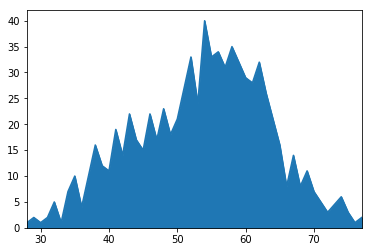

In [39]:
# heart_disease['train']['Column1'].plot.hist(bins=20)
heart_disease['train']['Column1'].value_counts().sort_index().plot.area()

- <b>Bivariate data visualization</b>

- <b>Multivariate data visualization</b>

- <b>Dimensionality reduction</b>

## Data preprocessing

2 jenis:
1. numeric
    - preprocess: normalize
    - null: mean or median, or buat model yang ditrain di datayang ganull, terus predict null
2. categorical
    1. Nominal: urutan gangaruh (fakultas)
         - preprocess: one hot encoding
    2. ordinal: categorical yang urutan ngaruh (rating)
         - preprocess: label encoding pd.get dummies

## Experiment